In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx pygraphviz matplotlib

In [2]:
# Plots
import networkx as nx
from networkx import Graph, DiGraph
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data
from itertools import combinations
from typing import List, Set
import random

# An Implementation of the D-Separation Algorithm



By Alessio Zanga, Niccolò Rocchi and Fabio Stella

## Abstract

Let us give some essential definitions:

* We say that a path $p$ is **blocked** by a set of nodes $\mathbf{S}$ if at least one of these two conditions holds:

  1. $p$ contains a **chain** $A \rightarrow B \rightarrow C$ or a **fork** $A \leftarrow B \rightarrow C$ and $B \in \mathbf{S}$
  2. $p$ contains a collider $A \rightarrow B \leftarrow C$ such that the collision node $B \notin \mathbf{S}$ and also $De(B) \cap \mathbf{S} = \emptyset$.

* We say that two nodes $X$ and $Y$ are **d-separated** by $\mathbf{S}$ if every path between $X$ and $Y$ is blocked by $\mathbf{S}$.

* We say that two sets of nodes $\mathbf{X}$ and $\mathbf{Y}$ are **d-separated** by $\mathbf{S}$ if, for every couple of nodes $X_i \in \mathbf{X}$ and $Y_i \in \mathbf{Y}$, $X_i$ and $Y_i$ are d-separated by $\mathbf{S}$.

* The **Global Markov assumption** allows us to read d-separation statements among nodes as conditional independence statements:
$$
X \perp \!\! \perp_G Y | \mathbf{S} \implies X \perp \!\! \perp_P Y | \mathbf{S}
$$

  where the LHS speaks about graphical properties, while the RHS regards probability properties among random variables.

While the definition  d-separation is correct, it cannot be directly translated into a functional form. The aim of this notebook is to exploit a different version of d-separation for providing a possible implementation.

## Introduction

An algorithmic definition of d-separation can be found in "Probabilistic Graphical Models: Principles and Techniques" by D. Koller and N. Friedman, page 136.

Let $\mathbf{X}$, $\mathbf{Y}$ and $\mathbf{Z}$ be three disjoint sets of $\mathbf{V}$ in the graph $G$. Let $\mathbf{S} = \mathbf{X} \cup \mathbf{Y} \cup \mathbf{Z}$ and $G^{[\mathbf{S}]}$ be the *upward closure* of $G$ over $\mathbf{S} \cup An(\mathbf{S})$. Let $H$ be the *moralized graph* of $G^{[\mathbf{S}]}$. Then *d-sep*$_G$($\mathbf{X}$, $\mathbf{Y}$, $\mathbf{Z}$) if and only if *u-sep*$_H$($\mathbf{X}, \mathbf{Y}, \mathbf{Z}$).

Let's split the definition step-by-step:



* Let $\mathbf{X}$, $\mathbf{Y}$ and $\mathbf{Z}$ be three disjoint sets of $\mathbf{V}$ in the graph $G$.
* Let $\mathbf{S} = \mathbf{X} \cup \mathbf{Y} \cup \mathbf{Z}$ and $G^{[\mathbf{S}]}$ be the *upward closure* of $G$ over $\mathbf{S} \cup An(\mathbf{S})$.
* Let $H$ be the *moralized graph* of $G^{[\mathbf{S}]}$.
* Then *d-sep*$_G$($\mathbf{X}, \mathbf{Y}, \mathbf{Z}$) if and only if *u-sep*$_H$($\mathbf{X}, \mathbf{Y}, \mathbf{Z}$).



Here it is an example of the whole process:

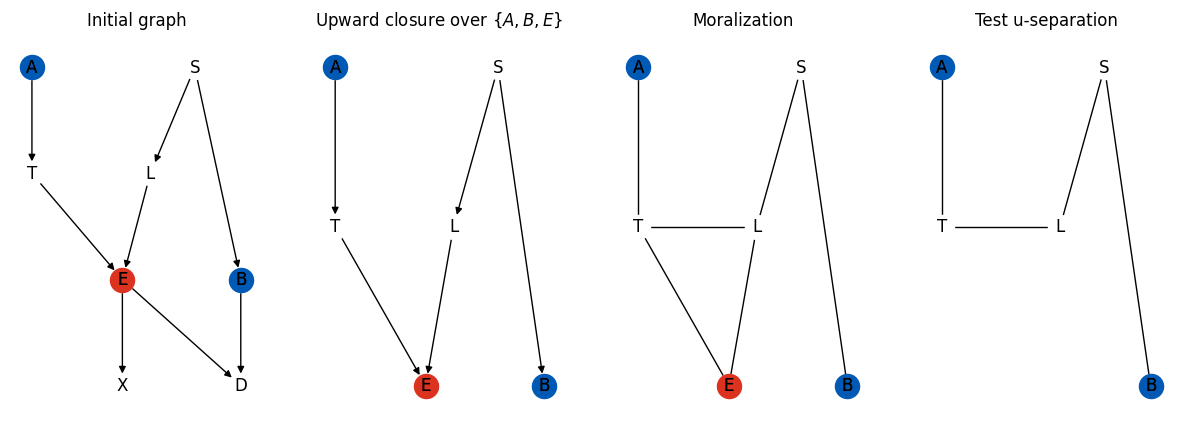

In [3]:
plt.figure(figsize = (15, 5))

# Initial graph
plt.subplot(1, 4, 1)
plt.gca().set_title("Initial graph")
G = DiGraph([("A", "T"), ("T", "E"), ("E", "X"), ("E", "D"), ("S", "L"), ("L", "E"), ("S", "B"), ("B", "D")])
nx.drawing.nx_agraph.write_dot(G,'G.dot')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos = pos, node_color="white", with_labels=True)
nx.draw(G.subgraph(["A", "B"]), pos = pos, node_color="#005AB5", with_labels=True)
nx.draw(G.subgraph(["E"]), pos = pos, node_color="#DC3220", with_labels=True)

# Upward closure
plt.subplot(1, 4, 2)
plt.gca().set_title("Upward closure over $\{A, B, E\}$")
G = DiGraph([("A", "T"), ("T", "E"), ("S", "L"), ("L", "E"), ("S", "B")])
nx.drawing.nx_agraph.write_dot(G,'G.dot')
nx.draw(G, pos = pos, node_color="white", with_labels=True)
nx.draw(G.subgraph(["A", "B"]), pos = pos, node_color="#005AB5", with_labels=True)
nx.draw(G.subgraph(["E"]), pos = pos, node_color="#DC3220", with_labels=True)

# Moralization
plt.subplot(1, 4, 3)
plt.gca().set_title("Moralization")
G = Graph([("A", "T"), ("T", "E"), ("S", "L"), ("L", "E"), ("S", "B"), ("T", "L")])
nx.drawing.nx_agraph.write_dot(G,'G.dot')
nx.draw(G, pos = pos, node_color="white", with_labels=True)
nx.draw(G.subgraph(["A", "B"]), pos = pos, node_color="#005AB5", with_labels=True)
nx.draw(G.subgraph(["E"]), pos = pos, node_color="#DC3220", with_labels=True)

# u-separation
plt.subplot(1, 4, 4)
plt.gca().set_title("Test u-separation")
G = Graph([("A", "T"), ("S", "L"),  ("S", "B"), ("T", "L")])
nx.drawing.nx_agraph.write_dot(G,'G.dot')
nx.draw(G, pos = pos, node_color="white", with_labels=True)
nx.draw(G.subgraph(["A", "B"]), pos = pos, node_color="#005AB5", with_labels=True)


## Implementation

 ### Plot style

Let's define a prettier plot style:

In [4]:
def draw(G, path: List[str] = []):
  plt.figure()
  pos = graphviz_layout(G, prog = "dot")
  for v in G.nodes():
    node_color = "white"
    if any(v in e for e in path):
      node_color = "orange"
    nx.draw_networkx_nodes(
        G,
        pos = pos,
        nodelist = [v],
        node_color = node_color,
        node_shape = "o",
        node_size = 4e2,
        edgecolors = "black",
        margins = 0.2
      )
  nx.draw_networkx_labels(G, pos = pos, font_size = 15)
  for e in G.edges():
    width = 1.0
    edge_color = "black"
    if e in path:
      width = 2
      edge_color = "orange"
    nx.draw_networkx_edges(
        G,
        pos = pos,
        edgelist = [e],
        edge_color = edge_color,
        width = width,
        arrowsize = 15,
    )

### A focus on [set operators](https://docs.python.org/3/library/stdtypes.html#set) in Python

In [5]:
# The boolean evaluation of an empty set is False.
print("Boolean({}): ", bool(set()))
# The boolean evaluation of a non-empty set is True.
print("Boolean({'X', 'Y', 'Z'}): ", bool({"X", "Y", "Z"}))
# The union operator is '|'.
print(
  "{'X', 'Y'}  ∪  {'Y', 'Z'} == {'X', 'Y', 'Z'}: ",
   {"X", "Y"}  |  {"Y", "Z"} == {"X", "Y", "Z"}
)
# The intersection operator is '&'.
print(
  "{'X', 'Y'}  ∩  {'Y', 'Z'} == {'Y'}: ",
   {"X", "Y"}  &  {"Y", "Z"} == {"Y"}
)
# The difference operator is '-'.
print(
  "{'X', 'Y'}  \  {'Y', 'Z'} == {'X'}: ",
   {"X", "Y"}  -  {"Y", "Z"} == {"X"}
)
# The "subset or equal" operator is '<='.
print(
  "{'X', 'Y'}  ⊆  {'Y', 'Z'}: ",
   {"X", "Y"}  <= {"Y", "Z"}
)

Boolean({}):  False
Boolean({'X', 'Y', 'Z'}):  True
{'X', 'Y'}  ∪  {'Y', 'Z'} == {'X', 'Y', 'Z'}:  True
{'X', 'Y'}  ∩  {'Y', 'Z'} == {'Y'}:  True
{'X', 'Y'}  \  {'Y', 'Z'} == {'X'}:  True
{'X', 'Y'}  ⊆  {'Y', 'Z'}:  False


### Implementing the Upward Closure of Directed Graphs


A collider $X \rightarrow Z \leftarrow Y$ is said to be an **immorality** (or **v-structure**) if there isn't any edge between $X$ and $Y$.

The moral graph of $G$ itself is not the right construct, because **there are paths in the undirected graph that correspond to colliders in $G$ that may or may not be blocked**.

For example, if our graph $G$ is $X \rightarrow Z \leftarrow Y$ and $Z$ is not observed, d-separation tells us that $X$ and $Y$ are independent, but the moralized graph for $G$ is the complete undirected graph, which does not have the same independence.

We first want to eliminate immoralities that are **not open** (i.e. blocked), so as to remove such cases.

To do so, we first construct a subgraph where we **remove all immoralities that do not have an observed descendant**. The elimination of such nodes does not change the independence properties of the distribution over the remaining variables, but does eliminate paths in the graph involving immoralities that are not open.

This process is called the **upward closure**, which consists in building the subgraph given a set of nodes and their ancestors.

In [6]:
def ancestors(G: DiGraph, S: Set[str]) -> Set[str]:
  """Compute the set of ancestors in G for a given set of nodes S."""
  An_S = {an_s for s in S for an_s in nx.ancestors(G, s)}
  #
  # Which is equivalent to:
  #
  # An_S = set()
  # for s in S:
  #   for an_s in nx.ancestors(G, s):
  #     An_S = An_S | {an_s}
  #
  return An_S

In [7]:
def upward_closure(G: DiGraph, S: Set[str]) -> DiGraph:
  """Compute the upward closure of G for a given set of nodes S."""
  return G.subgraph(S | ancestors(G, S))

### Implementing the Moral Graph of Directed Graphs

If directed graphs where equivalent to undirected graphs, then d-separation could be achieved by turning a directed graph into an undirected graph. Unfortunately, this is not the case. Or, at least, the **mapping** step is not that... direct.

A **moral graph** $H$ is an **undirected copy** of a directed graph $G$, where **each pair of parents** of each node in $G$ is connected by an undirected edge.

The difficult step here is not to implement the algorithm, but to **undestand why we need to connect the parents** of each node. We try now to catch the point, but if you want the full story, please, refer to [Markov Networks](https://en.wikipedia.org/wiki/Markov_random_field) and ask a Master Thesis to us.

For each immorality $X \rightarrow W \leftarrow Y$ in $G^{[\mathbf{S}]}$, we have that either $W$ belongs to the ancestors of $\mathbf{Z}$, or it belongs to the ancestors of $A$ (or $B$). In the first case, the immorality path is open and association flows between $X$ and $Y$. In the second case, it doesn't really matter if the association flows across the immorality, because it is enough that it flows between $A$ (or $B$) and $X$, $Y$.

However, in case of $W$ belongs to $\mathbf{Z}$, it will block any undirected path passing through it in the undirected graph $H$. So, we cannot just turn $G$ to be undirected. In order to preserve the associational behaviour we mentioned before, we connect any couple of parents, in case they are not already connected.

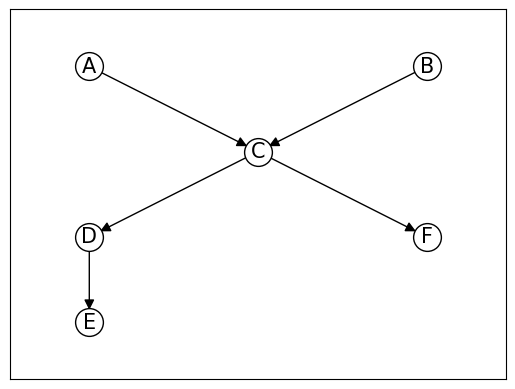

In [8]:
G = DiGraph([("A", "C"), ("B", "C"), ("C", "D"), ("D", "E"), ("C", "F")])

draw(G)

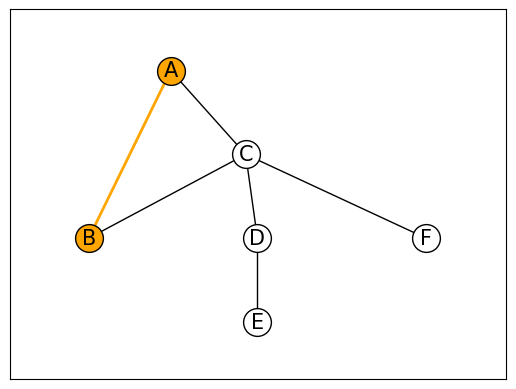

In [9]:
# Build an undirected copy.
H = G.to_undirected()
# Compute the edge to add.
E = set()
for v in G.nodes():
  Pa_v = G.predecessors(v)
  for (u, w) in combinations(Pa_v, 2):
    E = E | {(u, w)}
# Add the required edges.
H.add_edges_from(E)
# Draw the moralized graph.
draw(H, E)

In [10]:
def moral(G: DiGraph) -> Graph:
  """Compute the moral graph of G."""
  # Build an undirected copy of G.
  H = G.to_undirected()
  # For each node, for each *pair* of parents, add an edge into H.
  H.add_edges_from(e for v in G.nodes() for e in combinations(G.predecessors(v), 2))
  #
  # Which is equivalent to:
  #
  # for v in G.nodes():
  #   Pa_v = G.predecessors(v)
  #   for (u, w) in combinations(Pa_v, 2):
  #     H.add_edge(u, w)
  #
  return H

### Implementing the Graphical Separation for Undirected Graphs

Graphical separation in undirected graphs reduces to **check whether a path between nodes exists**. Specifically, two nodes $X$ and $Y$ are separated if there is no path that connects them. Since graphical separation **depends on the definition of path**, in undirected graphs it is often referred as *u(ndirected)*-separation, while in directed graphs is called *d(irected)*-separation.

Let's make an example:

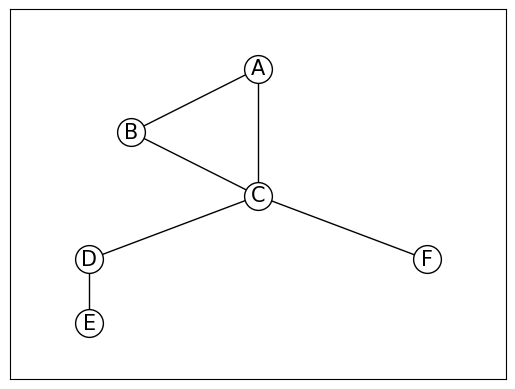

In [11]:
H = Graph([("A", "B"), ("A", "C"), ("B", "C"), ("C", "D"), ("D", "E"), ("C", "F")])
draw(H)

To check for **unconditional** separation one must **check for the existence of a path in the original graph**.

In [12]:
print("Is 'A' u-separated from 'E'? ", not nx.has_path(H, "A", "E"))

Is 'A' u-separated from 'E'?  False


Indeed, **a path exists**:

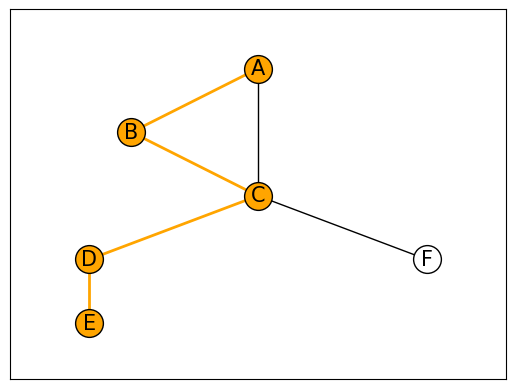

In [13]:
path = next(nx.all_simple_edge_paths(H, "A", "E"))  # Get the first path.
draw(H, path)

To check for **conditional** separation one must **block**, i.e. disrupt, the paths dependant on the conditioning node. Therefore, we reduce this problem to checking for **unconditional** separation in a **modified graph** where the **conditioning nodes are removed**.

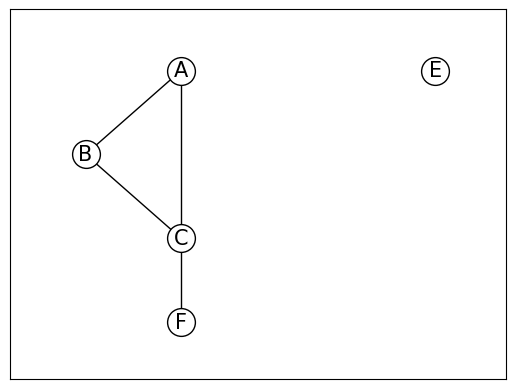

In [14]:
# Remove the conditioning nodes.
H_prime = H.copy()
H_prime.remove_node("D")
# Draw the conditioned graph.
draw(H_prime)

In [15]:
print("Is 'A' u-separated from 'E' given 'D'? ", not nx.has_path(H_prime, "A", "E"))

Is 'A' u-separated from 'E' given 'D'?  True


If we want to generalize this algorithm to sets instead of just nodes, we can rely on **connected components** instead of just paths. In this case, two disjoint sets of nodes $\mathbf{X}$ and $\mathbf{Y}$ are u-separated if every node in $\mathbf{X}$ is not in a connected component with a node in $\mathbf{Y}$.

In [16]:
Cs = list(nx.connected_components(H_prime))
for c in Cs:
  print(c)

{'A', 'B', 'C', 'F'}
{'E'}


Let's make another example, this time by exploiting connected components:

In [17]:
print(
  "Is {'A'} u-separated from {'B'} given {'D'}? ",
  not(any((bool(C & {"A"})) and bool(C & {"B"}) for C in nx.connected_components(H_prime)))
)

Is {'A'} u-separated from {'B'} given {'D'}?  False


In fact, a path between $A$ and $B$ exists in the same connected component:

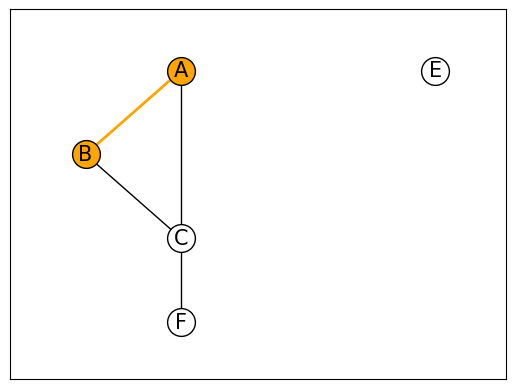

In [18]:
path = next(nx.all_simple_edge_paths(H_prime.subgraph(Cs[0]), "A", "B"))
draw(H_prime, path)

Now we can implement the u-separation over set of nodes:

In [19]:
def are_u_separated(H: Graph, X: Set[str], Y: Set[str], Z: Set[str]) -> bool:
  """Check the u-separation in H of X, Y and Z."""
  # Remove the nodes in Z from H to disrupt potential paths from X to Y.
  H_Z = H.subgraph(set(H.nodes()) - Z)
  # Check if there exists at least one path between a node in X and a node in Y.
  are_separated = not(any((bool(C & X) and bool(C & Y)) for C in nx.connected_components(H_Z)))
  #
  # Which is equivalent to:
  #
  # for C in nx.connected_components(H_Z):
  #   if bool(C & X) and bool(C & Y):
  #     return False
  # return True
  #
  return are_separated

### Implementing the Graphical Separation for Directed Graphs

Now we can implement the d-separation by assembling the previous algorithms.

In [20]:
X = {"A"}
Y = {"E"}
Z = {"D"}
# Compute the upward closure.
S = X | Y | Z
G_S = upward_closure(G, S)
# Moralize the upward closure.
H = moral(G_S)
# Check for u-separation in the moralized graph.
print("Is {'A'} d-separated from {'E'} given {'D'}? ", are_u_separated(H, X, Y, Z))

Is {'A'} d-separated from {'E'} given {'D'}?  True


Tying it all together:

In [21]:
def are_d_separated(G: DiGraph, X: Set[str], Y: Set[str], Z: Set[str]) -> bool:
  """Check the d-separation in G of X, Y and Z."""
  # *We also require that X and Y are non-empty.*
  assert bool(X) and bool(Y)
  # Let S = X U Y U Z ...
  S = X | Y | Z
  # Let X, Y and Z be three disjoint sets of V in the graph G.
  assert not(bool(X & Y | Y & Z | X & Z)) and (S <= set(G.nodes()))
  # ... and G[S] be the upward closure of G over S U An(S).
  G_S = upward_closure(G, S)
  # Let H be the moralized graph of G[S].
  H = moral(G_S)
  # Then d-sep_G(X, Y, Z) if and only if u-sep_H(X, Y, Z).
  are_separated = are_u_separated(H, X, Y, Z)
  # Return result.
  return are_separated

Then we have: `are_d_separated(G, X, Y, Z)` if and only if `are_u_separated(H, X, Y, Z)`:

In [22]:
print("Is {'A'} d-separated from {'E'} given {'D'}? ", are_d_separated(G, X, Y, Z))

Is {'A'} d-separated from {'E'} given {'D'}?  True


## Tests

Let's test it on a new example:

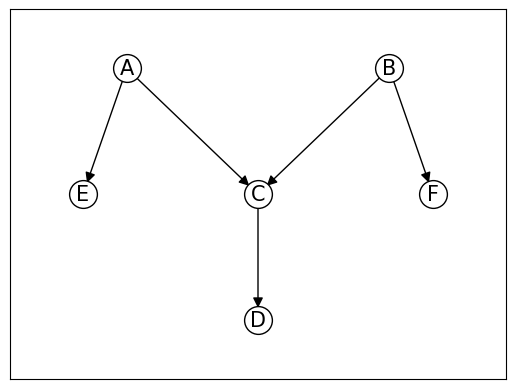

In [23]:
G = DiGraph([("A", "C"), ("B", "C"), ("C", "D"), ("A", "E"), ("B", "F")])
draw(G)

In [24]:
assert are_d_separated(G, {"E"}, {"F"}, set())

In [25]:
assert are_d_separated(G, {"E"}, {"B"}, set())

In [26]:
assert are_d_separated(G, {"E"}, {"F"}, {"B"})

In [27]:
assert are_d_separated(G, {"E"}, {"B"}, {"F"})

In [28]:
assert are_d_separated(G, {"E"}, {"F"}, {"A", "C"})

In [29]:
assert are_d_separated(G, {"E"}, {"F"}, {"B", "D"})

In [30]:
assert are_d_separated(G, {"A"}, {"B"}, set())

In [31]:
assert are_d_separated(G, {"A"}, {"F"}, set())

In [32]:
assert are_d_separated(G, {"A"}, {"F"}, {"E"})

In [33]:
assert are_d_separated(G, {"D"}, {"F"}, {"C"})

In [34]:
assert not are_d_separated(G, {"E"}, {"A"}, set())

In [35]:
assert not are_d_separated(G, {"E"}, {"C"}, set())

In [36]:
assert not are_d_separated(G, {"E"}, {"F"}, {"C"})

In [37]:
assert not are_d_separated(G, {"E"}, {"F"}, {"D"})

In [38]:
assert not are_d_separated(G, {"E"}, {"A"}, {"C", "D"})

In [39]:
assert not are_d_separated(G, {"A"}, {"C"}, set())

In [40]:
assert not are_d_separated(G, {"A"}, {"D"}, set())

In [41]:
assert not are_d_separated(G, {"A"}, {"B"}, {"C"})

In [42]:
assert not are_d_separated(G, {"A"}, {"B"}, {"C", "D"})

In [43]:
assert not are_d_separated(G, {"B"}, {"F"}, set())